In [2]:
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [58]:
def order_book(month,day):
    data = []
    datapath = '/home/bigdatas16/SGX-OrderBook-Tick-Data-Trading-Strategy-/High_Frequency_Trading_Strategy_using_machine_learning/Limit_Order_Book_Best_3/order_book_3_2014'\
                + '_' + str(month) + '_' + str(day) + '.csv'
    order_book = pd.read_csv(datapath,sep=',')
    bid_price_1 = np.array(map(float,order_book['Bid'][1::4]))/100.0
    bid_price_2 = np.array(map(float,order_book['Bid'][2::4]))/100.0
    bid_price_3 = np.array(map(float,order_book['Bid'][3::4]))/100.0
    timestamp = np.array(order_book['Bid_Quantity'][0::4])
    bid_quantity_1 = np.array(map(float,order_book['Bid_Quantity'][1::4]))
    bid_quantity_2 = np.array(map(float,order_book['Bid_Quantity'][2::4]))
    bid_quantity_3 = np.array(map(float,order_book['Bid_Quantity'][3::4]))
    ask_price_1 = np.array(map(float,order_book['Ask'][1::4]))/100.0
    ask_price_2 = np.array(map(float,order_book['Ask'][2::4]))/100.0
    ask_price_3 = np.array(map(float,order_book['Ask'][3::4]))/100.0
    ask_quantity_1 = np.array(map(float,order_book['Ask_Quantity'][1::4]))
    ask_quantity_2 = np.array(map(float,order_book['Ask_Quantity'][2::4]))
    ask_quantity_3 = np.array(map(float,order_book['Ask_Quantity'][3::4]))
    
    bid_quantity_1[isnan(bid_quantity_1)] = 0
    bid_quantity_2[isnan(bid_quantity_2)] = 0
    bid_quantity_3[isnan(bid_quantity_3)] = 0
    ask_quantity_1[isnan(ask_quantity_1)] = 0
    ask_quantity_2[isnan(ask_quantity_2)] = 0
    ask_quantity_3[isnan(ask_quantity_3)] = 0
    
    return timestamp,order_book,bid_price_1,bid_price_2,bid_price_3,bid_quantity_1,\
            bid_quantity_2,bid_quantity_3,ask_price_1,ask_price_2,ask_price_3,ask_quantity_1,\
            ask_quantity_2,ask_quantity_3

In [4]:
def time_transform(timestamp_time):
    time_second_basic = []
    time_second = []
    for i in range(0,len(timestamp_time),1):
        second = float(timestamp_time[i][11])*36000 + float(timestamp_time[i][12])*3600+\
                    float(timestamp_time[i][14])*600 + float(timestamp_time[i][15])*60+\
                    float(timestamp_time[i][17])*10 + float(timestamp_time[i][18])  
        time_second_basic.append(second - 32400.0)
        time_second.append(second)
    return np.array(time_second),np.array(time_second_basic)

In [182]:
def traded_label_micsecond(time1,time2,time_second_basic,bid_price_1,ask_price_1,traded_time):
    traded = []
    index_ = []
    micsecond = time_second_basic[np.where((time_second_basic >= time1) & (time_second_basic <= time2))]
    for i in range(0,len(micsecond),1):
        index = np.where(time_second_basic <= micsecond[i])[0][-1]
        if i == 0:
            index_.append(index)
        if i == len(micsecond) - 1:
            index_.append(index)
        index_min = np.where(time_second_basic <= micsecond[i] + traded_time)[0][-1]
        if bid_price_1[index] > min(ask_price_1[index:index_min]):
            traded.append(1)
        else:
            traded.append(0)
        #print index,index_min
    return traded,index_

In [122]:
def rise_ask(Ask1,timestamp_time_second,before_time):
    Ask1[Ask1 == 0] = mean(Ask1)
    rise_ratio = []
    index = np.where(timestamp_time_second >= before_time)[0][0]    
    #open first before_time mins
    for i in range(0,index,1):
        rise_ratio_ = round((Ask1[i] - Ask1[0])*(1.0)/Ask1[0]*100,5)
        rise_ratio.append(rise_ratio_)
    for i in range(index,len(Ask1),1):
        index_start = np.where(timestamp_time_second[:i] >= timestamp_time_second[i] - before_time)[0][0]
        rise_ratio_ = round((Ask1[i] - Ask1[index_start])*(1.0)/Ask1[index_start]*100,5)
        rise_ratio.append(rise_ratio_)
    return rise_ratio

In [91]:
def weight_pecentage(w1,w2,w3):
    Weight_Ask = (w1 * ask_quantity_1 + w2 * ask_quantity_2 + w3 * ask_quantity_3)
    Weight_Bid = (w1 * bid_quantity_1 + w2 * bid_quantity_2 + w3 * bid_quantity_3)
    W_AB = Weight_Ask/Weight_Bid
    W_A_B = (Weight_Ask - Weight_Bid)/(Weight_Ask + Weight_Bid)
    return W_AB,W_A_B

In [59]:
month = 1
day = 2
timestamp,order_book,bid_price_1,bid_price_2,bid_price_3,\
bid_quantity_1,bid_quantity_2,bid_quantity_3,\
ask_price_1,ask_price_2,ask_price_3,ask_quantity_1,\
ask_quantity_2,ask_quantity_3 = order_book(month,day)

In [60]:
time_second,time_second_basic = time_transform(timestamp)

In [191]:
traded_time = 300
# 09:00 ~ 09:15
time1 = 0
time2 = 900
traded_micsecond_1,index_1 = traded_label_micsecond(time1,time2,time_second_basic,\
                                                    bid_price_1,ask_price_1,traded_time)
#len(np.where(np.array(traded_micsecond_1) == 0)[0]),len(np.where(np.array(traded_micsecond_1) == 1)[0])

# 09:15 ~ 11:30
time1 = 900+1
time2 = 9000
traded_micsecond_2,index_2 = traded_label_micsecond(time1,time2,time_second_basic,\
                                                    bid_price_1,ask_price_1,traded_time)
#len(np.where(np.array(traded_micsecond_2) == 0)[0]),len(np.where(np.array(traded_micsecond_2) == 1)[0])

# 11:30 ~ 1:00
time1 = 9000+1
time2 = 14400
traded_micsecond_3,index_3 = traded_label_micsecond(time1,time2,time_second_basic,\
                                                    bid_price_1,ask_price_1,traded_time)
#len(np.where(np.array(traded_micsecond_3) == 0)[0]),len(np.where(np.array(traded_micsecond_3) == 1)[0])

# 01:00 ~ 16:00
time1 = 14400+1
time2 = 25200 - traded_time
traded_micsecond_4,index_4 = traded_label_micsecond(time1,time2,time_second_basic,\
                                                    bid_price_1,ask_price_1,traded_time)
#len(np.where(np.array(traded_micsecond_4) == 0)[0]),len(np.where(np.array(traded_micsecond_4) == 1)[0])

In [193]:
index_1,index_2,index_3,index_4

([294, 1021], [1023, 29798], [29799, 31276], [31279, 46529])

In [169]:
index_1,index_2,index_3,index_4

([294, 1021], [1023, 29798], [29799, 31276], [31279, 46412])

In [194]:
import time 
start = time.time()

before_time = 60.0 * 5 # second
index = np.where(time_second_basic <= 0.0)[0][-1]   
Ask1 = ask_price_1[np.where(time_second_basic <= 0.0)[0][-1]:]
rise_ratio_ask = rise_ask(Ask1,time_second_basic,before_time)

#Weight Depth
w1,w2,w3 = [50.0,30.0,20.0]
W_AB,W_A_B = weight_pecentage(w1,w2,w3)

end = time.time()  
print "Total time = %f"%(end - start) 

Total time = 0.951856


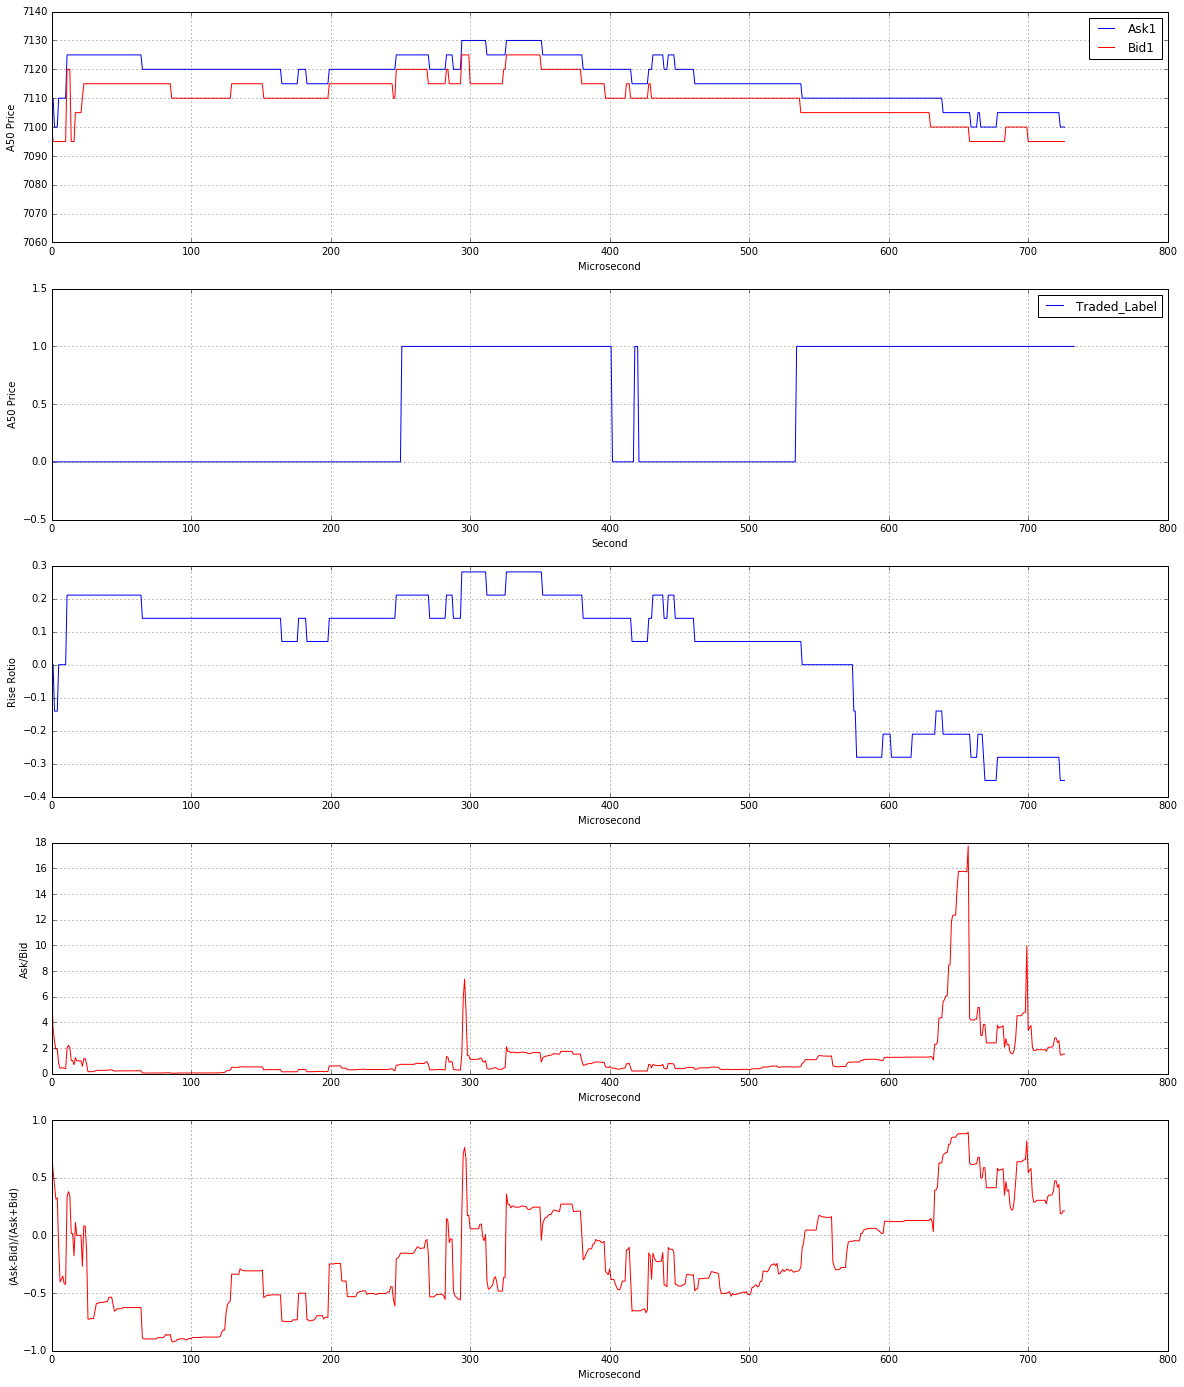

In [195]:
#Open 0 ~ 09:15
time1 ,time2 = index_1
plt.figure(figsize = (20,24))
plt.subplot(511)
plt.grid()
plot(ask_price_1[time1:time2],label = 'Ask1',color = 'b')
plot(bid_price_1[time1:time2],label = 'Bid1',color = 'r')
plt.ylim(7060,7140)
plt.xlabel("Microsecond")
plt.ylabel("A50 Price")
plt.legend(loc = 1)

plt.subplot(512)
plt.grid()
plot(traded_micsecond_1,label = 'Traded_Label',color = 'b')
plt.ylim(-0.5,1.5)
plt.xlabel("Second")
plt.ylabel("A50 Price")
plt.legend(loc = 1)

plt.subplot(513)
plt.grid()
plot(rise_ratio_ask[0:(time2-time1)],label = 'Traded_Label',color = 'b')
plt.xlabel("Microsecond")
plt.ylabel("Rise Rotio")

plt.subplot(514)
plt.grid()
plot(W_AB[time1:time2],label = 'Ask/Bid',color = 'r')
#plt.ylim(0,400)
plt.xlabel("Microsecond")
plt.ylabel("Ask/Bid")

plt.subplot(515)
plt.grid()
plot(W_A_B[time1:time2],label = '(Ask-Bid)/(Ask+Bid)',color = 'r')
#plt.ylim(0,400)
plt.xlabel("Microsecond")
plt.ylabel("(Ask-Bid)/(Ask+Bid)")

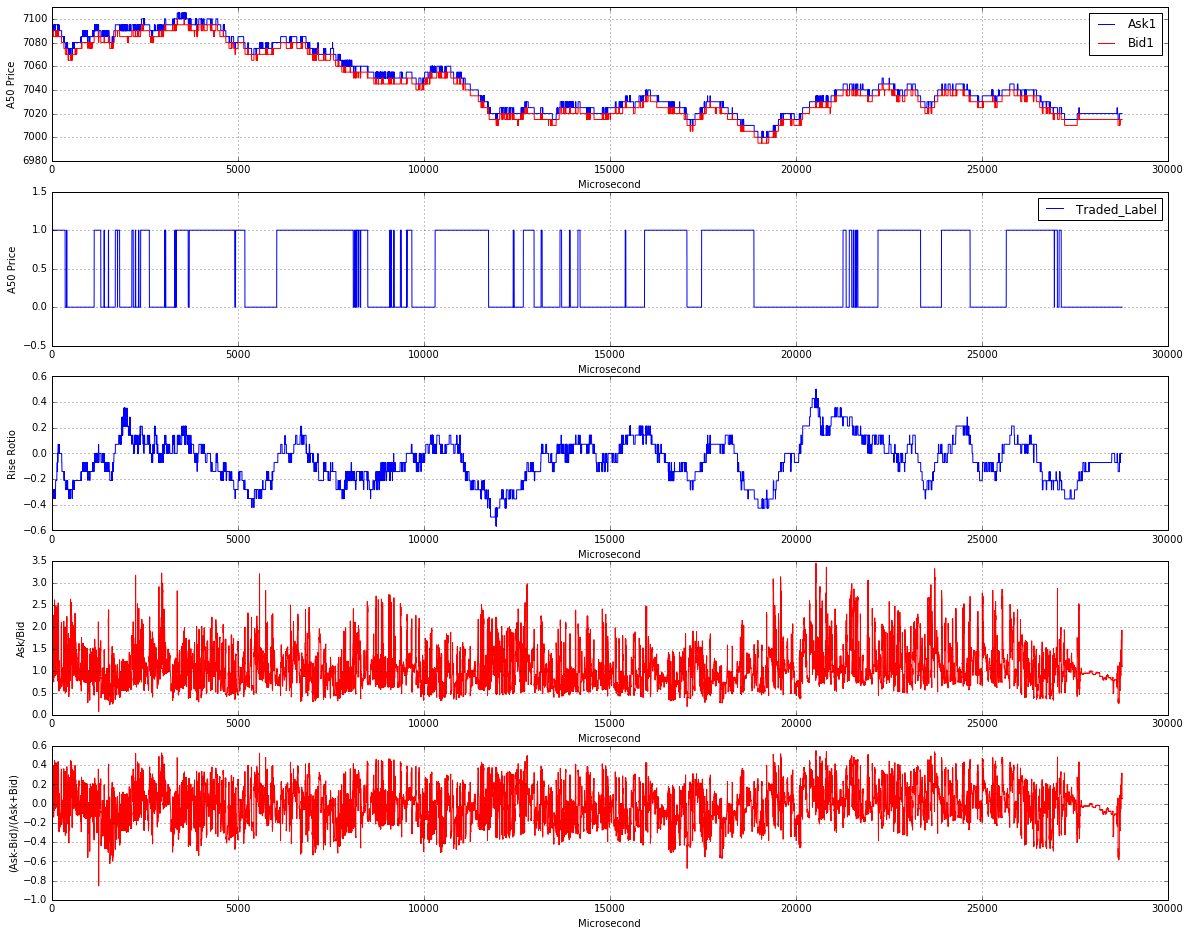

In [196]:
#Open 09:15 ~ 11:30
time01 ,time02 = index_1
time1 ,time2 = index_2
plt.figure(figsize = (20,16))
plt.subplot(511)
plt.grid()
plot(ask_price_1[time1:time2],label = 'Ask1',color = 'b')
plot(bid_price_1[time1:time2],label = 'Bid1',color = 'r')
plt.ylim(6980,7110)
plt.xlabel("Microsecond")
plt.ylabel("A50 Price")
plt.legend(loc = 1)

plt.subplot(512)
plt.grid()
plot(traded_micsecond_2,label = 'Traded_Label',color = 'b')
plt.ylim(-0.5,1.5)
plt.xlabel("Microsecond")
plt.ylabel("A50 Price")
plt.legend(loc = 1)

plt.subplot(513)
plt.grid()
plot(rise_ratio_ask[time02-time01:][0:(time2-time1)],label = 'Traded_Label',color = 'b')
plt.xlabel("Microsecond")
plt.ylabel("Rise Rotio")

plt.subplot(514)
plt.grid()
plot(W_AB[time1:time2],label = 'Ask/Bid',color = 'r')
#plt.ylim(0,400)
plt.xlabel("Microsecond")
plt.ylabel("Ask/Bid")

plt.subplot(515)
plt.grid()
plot(W_A_B[time1:time2],label = '(Ask-Bid)/(Ask+Bid)',color = 'r')
#plt.ylim(0,400)
plt.xlabel("Microsecond")
plt.ylabel("(Ask-Bid)/(Ask+Bid)")

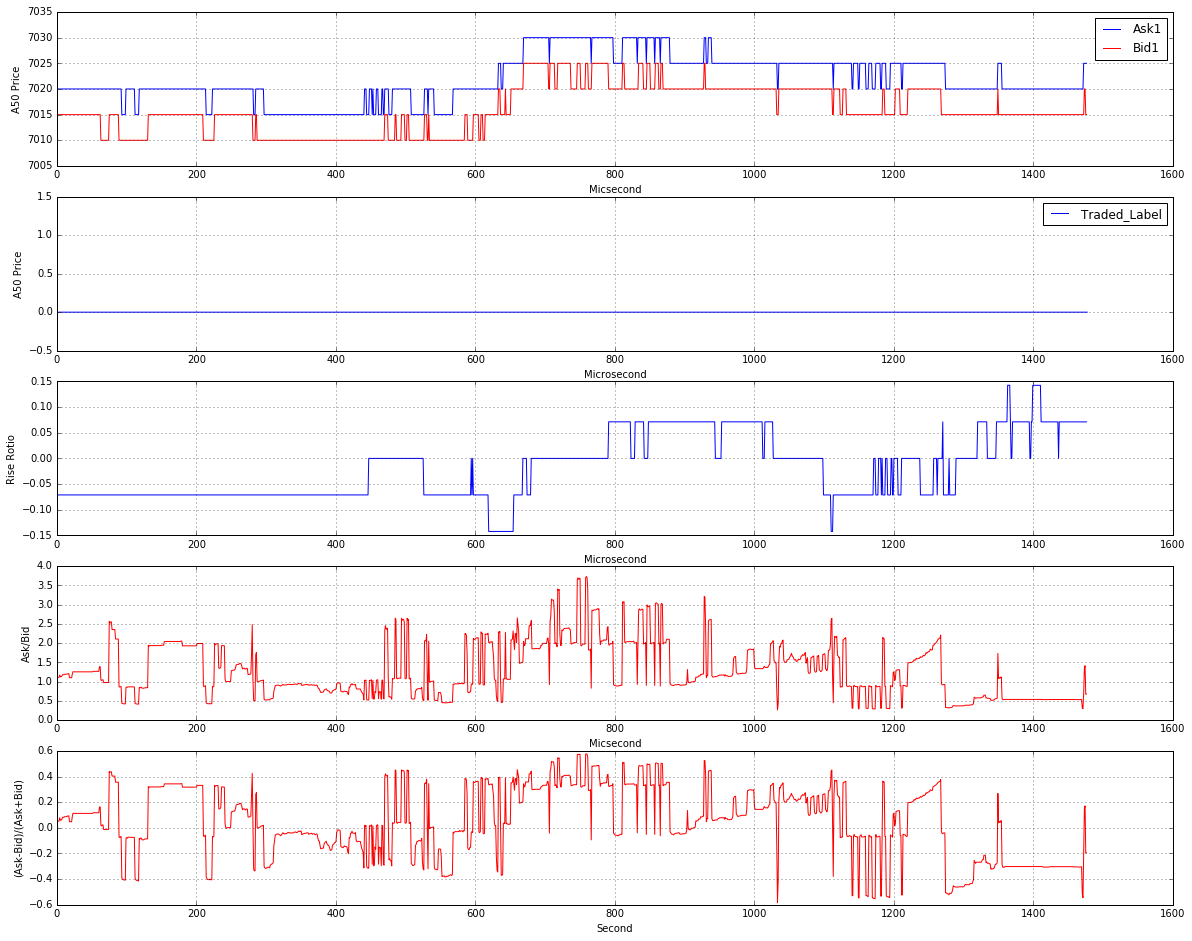

In [197]:
#Open 11:30 ~ 13:00 => china close
time01 ,time02 = index_2
time1 ,time2 = index_3
plt.figure(figsize = (20,16))
plt.subplot(511)
plt.grid()
plot(ask_price_1[time1:time2],label = 'Ask1',color = 'b')
plot(bid_price_1[time1:time2],label = 'Bid1',color = 'r')
plt.ylim(7005,7035)
plt.xlabel("Micsecond")
plt.ylabel("A50 Price")
plt.legend(loc = 1)

plt.subplot(512)
plt.grid()
plot(traded_micsecond_3,label = 'Traded_Label',color = 'b')
plt.ylim(-0.5,1.5)
plt.xlabel("Microsecond")
plt.ylabel("A50 Price")
plt.legend(loc = 1)

plt.subplot(513)
plt.grid()
plot(rise_ratio_ask[time02-time01:][0:(time2-time1)],label = 'Traded_Label',color = 'b')
plt.xlabel("Microsecond")
plt.ylabel("Rise Rotio")

plt.subplot(514)
plt.grid()
plot(W_AB[time1:time2],label = 'Ask/Bid',color = 'r')
plt.xlabel("Micsecond")
plt.ylabel("Ask/Bid")

plt.subplot(515)
plt.grid()
plot(W_A_B[time1:time2],label = '(Ask-Bid)/(Ask+Bid)',color = 'r')
plt.xlabel("Second")
plt.ylabel("(Ask-Bid)/(Ask+Bid)")

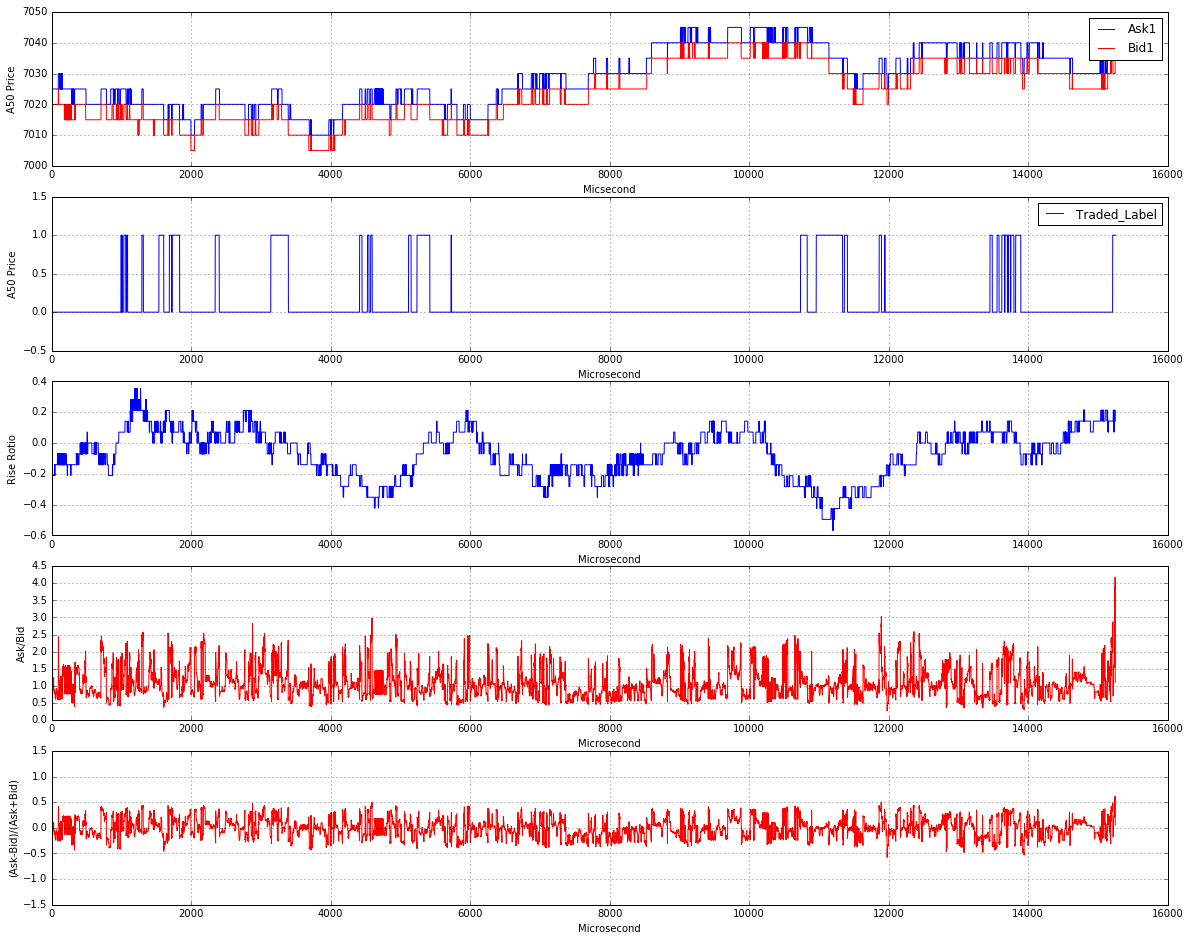

In [198]:
#Open 13:00 ~ 16:00
time01 ,time02 = index_3
time1,time2 = index_4
plt.figure(figsize = (20,16))
plt.subplot(511)
plt.grid()
plot(ask_price_1[time1:time2],label = 'Ask1',color = 'b')
plot(bid_price_1[time1:time2],label = 'Bid1',color = 'r')
plt.ylim(7000,7050)
plt.xlabel("Micsecond")
plt.ylabel("A50 Price")
plt.legend(loc = 1)

plt.subplot(512)
plt.grid()
plot(traded_micsecond_4,label = 'Traded_Label',color = 'b')
plt.ylim(-0.5,1.5)
plt.xlabel("Microsecond")
plt.ylabel("A50 Price")
plt.legend(loc = 1)

plt.subplot(513)
plt.grid()
plot(rise_ratio_ask[time02-time01:][0:(time2-time1)],label = 'Traded_Label',color = 'b')
plt.xlabel("Microsecond")
plt.ylabel("Rise Rotio")

plt.subplot(514)
plt.grid()
plot(W_AB[time1:time2],label = 'Ask/Bid',color = 'r')
plt.xlabel("Microsecond")
plt.ylabel("Ask/Bid")

plt.subplot(515)
plt.grid()
plot(W_A_B[time1:time2],label = '(Ask-Bid)/(Ask+Bid)',color = 'r')
plt.ylim(-1.5,1.5)
plt.xlabel("Microsecond")
plt.ylabel("(Ask-Bid)/(Ask+Bid)")